# Cover Type Classification

## Objective: Build a deep learning model to predict the forest cover type from different cartographic variables.

### Given
    1. Cover Types:
      - Spruce/Fir
      - Lodgepole Pine
      - Ponderosa Pine
      - Cottonwood/Willow
      - Aspen
      - Douglas-fir
      - Krummholz

    2. Dataset
      - File: `cover_data.csv`
      - Contains 581,012 observations
      - Each observation has 55 columns (54 features and the last one being the class)

### Assumptions
    1. Test Data: No separate test dataset provided, so a portion of the input must be held out as test data.
    2. Prediction Focus: No information on whether to prioritize precision or recall, so both should be maximized.

### Expected Output
    1. A high-performing deep learning model.
    2. Performance metrics over epochs (accuracy and loss plots).
    3. Classification metrics:
      - Heatmap of the confusion matrix
      - Classification report
    4. Conclusions, thoughts, and suggestions for improving classification accuracy.


In [ ]:
!pip install sweetviz

In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

### Define some helper functions

In [5]:
def prep_data(raw_df):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data

    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [6]:
def build_model(num_features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [14]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'/content/confusion_matrix.png')

In [8]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

### The main function below drives the entire code. It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [12]:
def main():
    infile = '/content/cover_data.csv'
    raw_df = pd.read_csv(infile)

    # EDA
    # Uncomment the below two lines to run EDA. Takes > 10 min to run.
    #my_report = sv.analyze(raw_df)
    #my_report.show_html()

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

Summary report of Keras classifier:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6060 - loss: 1.0234 - val_accuracy: 0.7408 - val_loss: 0.6121
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7474 - loss: 0.5979 - val_accuracy: 0.7591 - val_loss: 0.5635
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7643 - loss: 0.5518 - val_accuracy: 0.7761 - val_loss: 0.5278
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7766 - loss: 0.5208 - val_accuracy: 0.7849 - val_loss: 0.5039
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7874 - loss: 0.4978 - val_accuracy: 0.7931 - val_loss: 0.4867
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7955 - loss: 0.4809 - val_accuracy: 0.8005 - val_loss: 0.4706
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8027 - loss: 0.4647 - val_accuracy: 0.8047 - val_loss: 0.4597
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8074 - loss: 0.4543 - val_accu

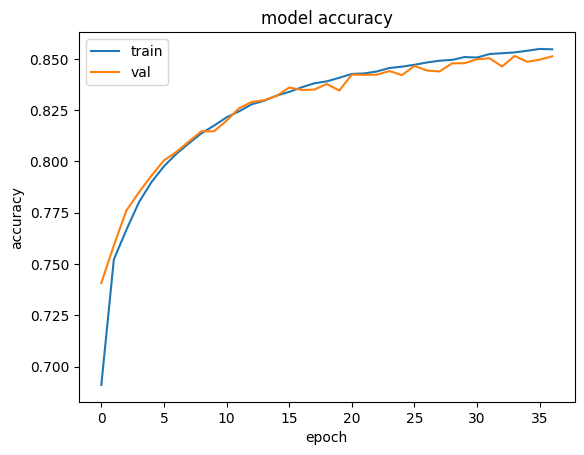

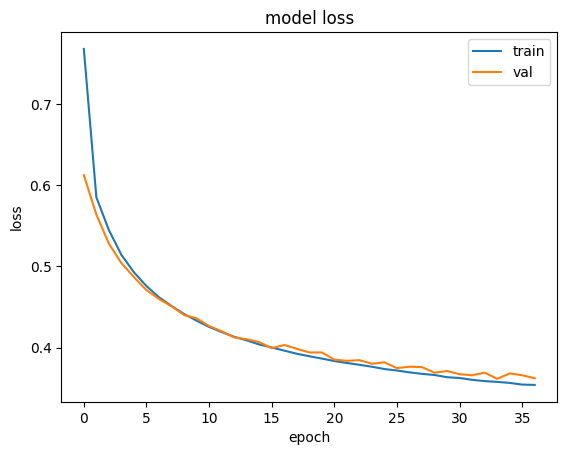

Test loss: 0.36105209589004517
Test accuracy: 0.8531449437141418
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.88      0.81      0.85     42368
   Lodgepole Pine       0.85      0.91      0.88     56661
   Ponderosa Pine       0.83      0.83      0.83      7151
Cottonwood/Willow       0.87      0.61      0.72       549
            Aspen       0.75      0.38      0.51      1899
      Douglas-fir       0.67      0.70      0.68      3473
        Krummholz       0.86      0.87      0.87      4102

         accuracy                           0.85    116203
        macro avg       0.82      0.73      0.76    116203
     weighted avg       0.85      0.85      0.85    116203



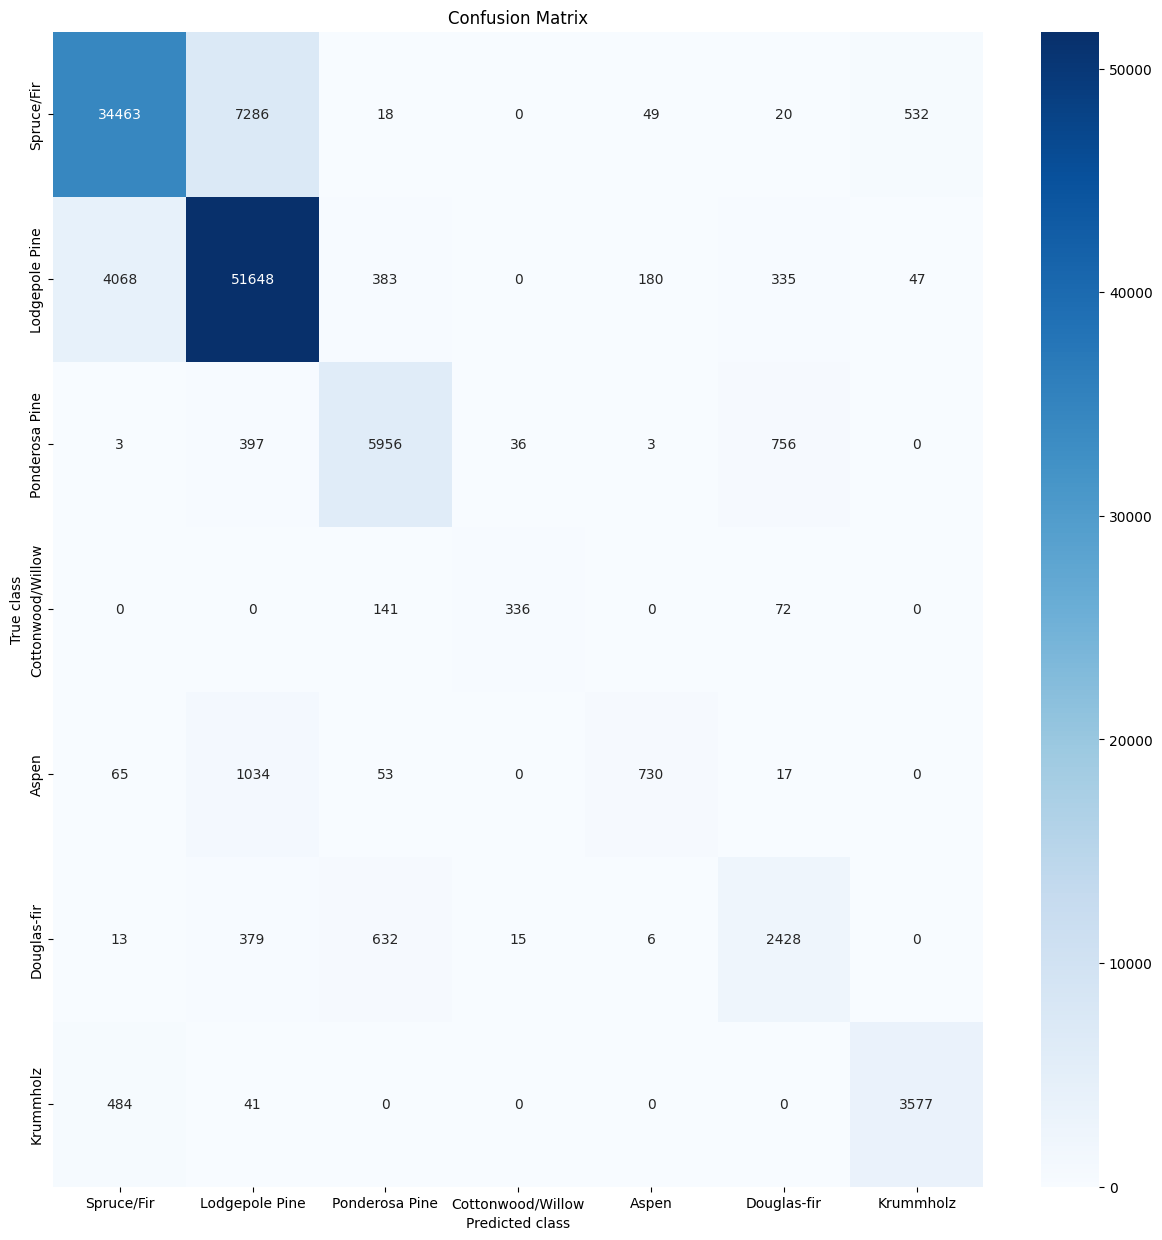

In [15]:
if __name__ == '__main__':
    main()